In [641]:
import pickle
import numpy as np
import PIL.Image
import itertools
from IPython.core.display import Image, display
import scipy.ndimage
import random
import numpy as np
import matplotlib.pylab as plt
import tqdm
import math
%matplotlib inline

# Загружаем датасет

In [642]:
with open('./hw_1_train.pickle', 'rb') as f:
    train = pickle.load(f)

with open('./hw_1_test_no_lables.pickle', 'rb') as f:
    test_no_lables = pickle.load(f)

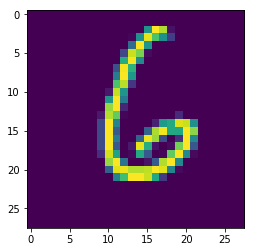

In [643]:
# Пример, как можно визуализировать данные
plt.imshow(test_no_lables['data'][9].reshape(28,28))

# Обучаем модель

In [644]:
class my_logistic_regression:
    
    
    def __init__(self, penalty=0.001, step=0.01, max_iter=100):
        np.random.seed(42)
        self.penalty = penalty
        self.step = step
        self.max_iter = max_iter
    
   
    def predict_proba(self, x, change=True):
        X = x.copy()
        if change:
            X = self._prepare_X(X)
        p = 1. / (1. + np.exp(-np.dot(X, self.w)))
        y = np.array(list(map(lambda x: [1.-x, x], p)))
        return y
    
    
    def predict(self, x, l1, l2, change=True):
        X = x.copy()
        if change:
            X = self._prepare_X(X)
        p = 1. / (1 + np.exp(-np.dot(X, self.w)))
        y = np.array(list(map(lambda x: l2 if x > .5 else l1, p)))
        return y
    
    
    def fit(self, x_train, y_train, x_test, y_test, l1, l2):
        _x_test = x_test.copy()
        _y_test = y_test.copy()
        _x_test = self._prepare_X(_x_test)
        _y_test = self._transform_labels(_y_test, l1, l2)
        X = x_train.copy()
        y = y_train.copy()
        X = self._prepare_X(X)
        y = self._transform_labels(y, l1, l2)
        loss_train = []
        loss_test = []
        acc_train = []
        acc_test = []
        self._initialize_w(X.shape[1])
        for _ in tqdm.tqdm_notebook(range(self.max_iter)):
            for _ in range(X.shape[0]):
                j = np.random.randint(0, X.shape[0])
                grad = - y[j] * X[j] / \
                    ( 1 + math.exp(y[j] * np.dot(self.w.T, X[j]) ) )\
                    + self.penalty * self.w
                self.w = self.w - self.step * grad
            
            y_hat_test = self.predict_proba(x_test)
            logloss_test = self.log_loss(y_test, y_hat_test)
            loss_test.append(logloss_test)
            
            y_hat_train = self.predict_proba(x_train)
            logloss_train = self.log_loss(y_train, y_hat_train)
            loss_train.append(logloss_train)    
            
            acc_train.append(self.generate_accuracy(y_train, self.predict(x_train, 5, 6)))
            acc_test.append(self.generate_accuracy(y_test, self.predict(x_test, 5, 6)))
            
        return (loss_train, loss_test, acc_train, acc_test)
           
    
    def log_loss(self,y_true, y_pred, eps=1e-15, normalize=True, sample_weight=None,
             labels=None):

        y_true=y_true.copy()
        transformed_labels=(y_true==6).astype(int)
        transformed_labels=np.expand_dims(transformed_labels,-1)

        if transformed_labels.shape[1] == 1:
            transformed_labels = np.append(1 - transformed_labels,
                                           transformed_labels, axis=1)
        # Clipping
        y_pred = np.clip(y_pred, eps, 1 - eps)
        
        y_pred /= y_pred.sum(axis=1)[:, np.newaxis]
        loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
        return loss.mean()    
    
    
    def generate_accuracy(self, y_true, y_pred):
        score = (y_true == y_pred)
        return score.mean()

    def _initialize_w(self,shape):
        self.w = np.random.normal(scale=0.001, size=shape)
    
    
    def _prepare_X(self, X, eps=0.0001):
        X = self._normalize_X(X, eps)
        X = self._add_w0_coeff(X)
        return X
    
    
    def _normalize_X(self, X, eps):
        mean_X = np.mean(X, axis=0)
        std_X = np.std(X, axis=0)
        X = (X - mean_X) / (std_X + eps)
        return X
    
    
    def _add_w0_coeff(self, X):
        return np.hstack([ np.ones((X.shape[0], 1)), X] )
    
    
    def _transform_labels(self, y, l1, l2):
        y[y==l1] = -1
        y[y==l2] = 1
        return y

In [645]:
from sklearn.model_selection import train_test_split

x = np.array(train['data'])
y = np.array(train['labels'])

# split data into train and test
x_train, x_test, y_train, y_test \
    = train_test_split(x, y, random_state=10)

In [646]:
logreg = my_logistic_regression(penalty=0.0005,step=0.00005, max_iter=250)
loss_train, loss_test, acc_train, acc_test \
    = logreg.fit(x_train, y_train, x_test, y_test, 5, 6)

In [647]:
# Look at log loss on test sample
y = y_test
y_hat = logreg.predict_proba(x_test)

logreg.log_loss(y, y_hat)

0.0504234551835498

# Оцениваем результат

Обязательно отрисуйте 2 графика:
- loss на обучающем и тестовом множесте
- % правильно классифицированных примеров на тестовом и обучающем множестве

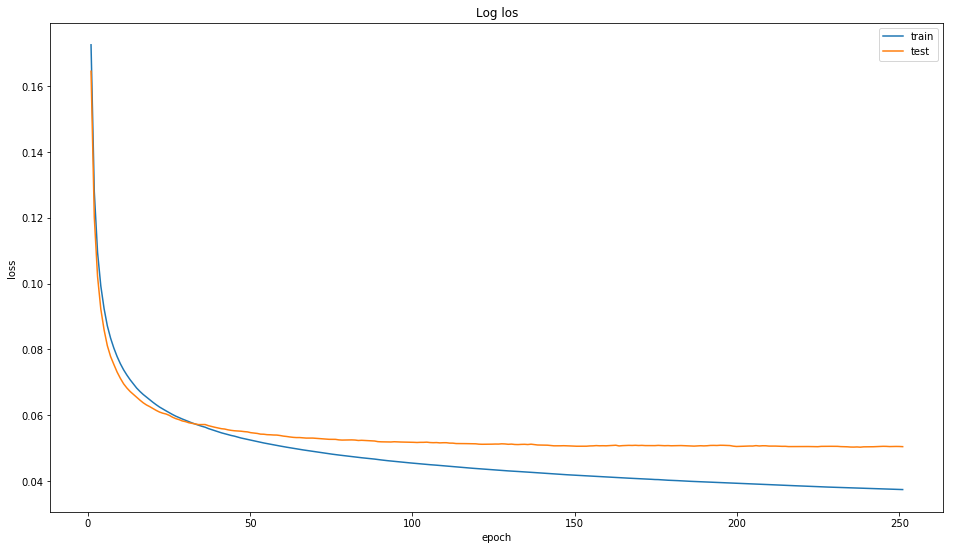

In [648]:
def draw_loss(loss_train, loss_test):
    plt.figure(figsize=(16, 9))
    plt.title("Log los")
    epoch = np.linspace(1, len(loss_train) + 1, num=len(loss_train))
    plt.plot(epoch, loss_train, label="train")
    plt.plot(epoch, loss_test, label="test")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.show()
    
draw_loss(loss_train, loss_test)

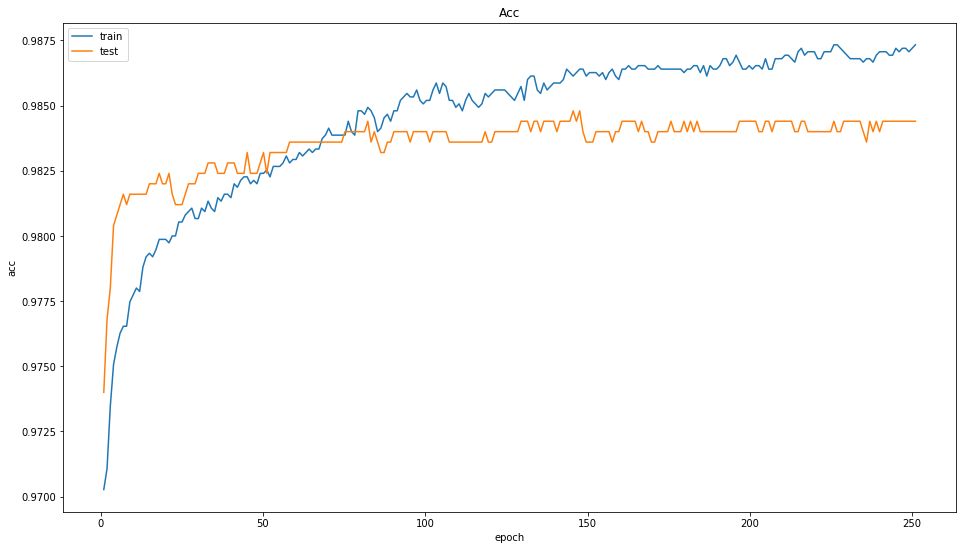

In [649]:
def draw_acc(acc_train, acc_test):
    plt.figure(figsize=(16,9))
    plt.title("Acc")
    epoch = np.linspace(1, len(acc_train) + 1, num=len(acc_train))
    plt.plot(epoch, acc_train, label="train")
    plt.plot(epoch, acc_test, label="test")
    plt.xlabel("epoch")
    plt.ylabel("acc")
    plt.legend()
    plt.show()
    
draw_acc(acc_train, acc_test)

# Сохраняем данные для кагла

https://www.kaggle.com/t/513ea517806348848dc78c4f41d44528

Результат записывается в простой текстовый файл. Первая строчка "Id,Prediction", далее для каждого примера из валидационного множества записывается его Id (порядковый номер, с нуля) и вероятность принадлежности к классу '6', например '123,0.12'.

Важно соблюдать тот же порядок следования элементов, что и в наборе данных. Нумерация id с 0

In [650]:
X = test_no_lables['data']

Y_pred = logreg.predict_proba(X)[:, 1]

with open('solution.csv', 'w') as fout:
    print("Id,Prediction", file=fout)
    for i in range(X.shape[0]):
        print(i, Y_pred[i], sep=',', file=fout)

# Сдача

1. Регистрируетесь на конкурс https://www.kaggle.com/t/34e77301ef914c5792e4f4306144a6b3 
1. Преодолеваете "Pass level" baseline
1. После того, как вы преодолеете baseline, присылайте ноутбук с решение по адресу **voropaev@corp.mail.ru**

# Внимание
- Тему письма писать в формате "[МФТИ][1] Фамилия"
- Внутри писма прикрепляете файл ноутбука с именем <ваша фамилия>.ipynb